In [2]:
import requests
import pandas as pd

base_url = 'http://localhost:8023/investment/'
investor_id = 108 
company_Name = 'IBM' 

api_url = f'{base_url}{investor_id}/{company_Name}'

response = requests.get(api_url)

if response.status_code == 200:
    # Extract JSON data from the response
    data = response.json()
    
    # Create a Pandas DataFrame from JSON data
    investmentData = pd.DataFrame([data])
    
    print("investmentData for Investor id:", investor_id)
    print("The length of investmentData is:", investmentData.shape)
    investmentData.head()
else:
    print(f"Failed request {response.status_code}")



investmentData for Investor id: 108
The length of investmentData is: (1, 11)


In [ ]:
startDate = data['startDate']
start_date = pd.Timestamp(startDate)
duration_months = int(data['duration'])
end_date = start_date + pd.Timedelta(days=duration_months * 30)
# Convert end date to the desired string format
end_date_str = end_date.strftime('%Y-%m-%d')
end_date_str

In [1]:
pip install flask-cors


Note: you may need to restart the kernel to use updated packages.


In [ ]:
%tb

In [ ]:
from flask import Flask, jsonify, request
import quantstats as qs
import pandas as pd
import requests
from flask_cors import CORS
import json
import matplotlib.pyplot as plt
  
app = Flask(__name__)
CORS(app) 


def fetch_investment_data(base_url, investor_id, company_Name):
    api_url = f'{base_url}/{investor_id}/{company_Name}'
    response = requests.get(api_url)
    
    if response.status_code == 200:
        # Extract JSON data from the response
        data = response.json()
        return data
    else:
        print(f"Failed request {response.status_code}")
        return None
    

    
def fetch_historical_data(base_url, symbol):
    api_url = f'{base_url}/{symbol}'
    response = requests.get(api_url)
    
    if response.status_code == 200:
        # Extract JSON data from the response
        data = response.json()
        return data
    else:
        print(f"Failed request {response.status_code}")
        return None

    
    

@app.route('/investment_performance', methods=['POST'])
def investment_performance():
    request_data = request.json
    
    if request_data is None or 'base_url' not in request_data or 'investor_id' not in request_data or 'company_Name' not in request_data or 'price_url' not in request_data:
        return jsonify({'error': 'Request data is missing or invalid.'}), 400

    # Fetch investment data
    investment_data = fetch_investment_data(request_data['base_url'], request_data['investor_id'], request_data['company_Name'])


    if investment_data is None:
        return jsonify({'error': 'Failed to fetch investment data.'}), 500

    # Extract relevant information from investment data
    initial_investment = investment_data['investmentAmount']
    current_value = investment_data['currentInvestmentAmount']

    # Fetch historical data
    historical_data = fetch_historical_data(request_data['price_url'], request_data['company_Name'])
    if historical_data:
        # Extract dates and close prices from historical data
        dates = list(historical_data.get("Time Series (5min)", {}).keys())
        close_prices = [float(data.get("4. close", 0)) for data in historical_data.get("Time Series (5min)", {}).values()]
        print("close_prices",close_prices)
        
        if dates and close_prices:
            # Create pandas DataFrame for historical prices
            historical_prices = pd.DataFrame({
                'Date': dates,
                'Close': close_prices
            })

            # Convert dates to datetime
            historical_prices['Date'] = pd.to_datetime(historical_prices['Date']) # list string--> list datetime

            # Set Date column as index
            #Pandas will use this column as an identifier to quickly access specific data in the DataFrame.
            #each DataFrame row is now identified by its date
            historical_prices.set_index('Date', inplace=True)
            
            # Load prices into quantstats
            qs.extend_pandas()

            # Convert historical prices to a Series
            prices_series = historical_prices['Close']
            print("prices_series",prices_series)
            
            # Calculate performance metrics using quantstats
            #.dropna() deletes the NaN values resulting from the percentage change calculation, as there will be no yield for the first observation.
            #calculates the daily percentage return between each period of two successive days.
            #The calculation of the daily return is based on the difference between the closing price of the asset at the end of the current day and the closing price of the previous day.
            qs_returns = prices_series.pct_change().dropna()
            qs_annual_return = qs_returns.mean() * 252  # Assuming 252 trading days in a year
            print(qs_annual_return)
            
            # Calculate Sharpe ratio and Sortino ratio
            sharpe_ratio = qs_returns.sharpe()
            sortino_ratio = qs_returns.sortino()
            print(sharpe_ratio, sortino_ratio)
            
            # gain_percentage 
            gain_percentage = ((current_value) / initial_investment)
            print("current_value",current_value)
            print(initial_investment)

            
            # Construct response data
            performance_data = {
                "total_return": (current_value - initial_investment) / initial_investment,
                "annual_return": qs_annual_return,
                "sharpe_ratio": sharpe_ratio,
                "sortino_ratio": sortino_ratio,
                'gain_percentage':gain_percentage,
          
                
            }

            return jsonify(performance_data)
        else:
            return jsonify({'error': 'No historical data available.'}), 500
    else:
        return jsonify({'error': 'Failed to fetch historical data.'}), 500

if __name__ == '__main__':
    app.run(port=5002)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5002/ (Press CTRL+C to quit)
127.0.0.1 - - [06/May/2024 23:43:18] "OPTIONS /investment_performance HTTP/1.1" 200 -


close_prices [168.79, 168.8, 168.25, 169.45, 169.409, 169.18, 169.5, 169.1, 169.4, 169.25, 169.25, 169.57, 169.25, 169.4, 169.094, 169.2, 169.25, 169.75, 169.34, 169.0, 168.94, 168.9, 168.7, 168.56, 168.39, 168.32, 168.23, 168.1, 167.95, 168.3, 167.5, 167.8, 169.57, 170.5, 171.47, 171.7, 171.96, 172.07, 172.12, 171.51, 171.61, 170.72, 172.2, 173.64, 173.4, 176.0, 179.01, 184.25, 184.1, 183.76, 183.53, 183.555, 183.78, 184.148, 184.115, 184.09, 183.79, 183.82, 183.55, 183.36, 183.33, 183.535, 183.47, 183.27, 183.135, 182.96, 183.05, 183.08, 183.19, 182.85, 183.305, 183.308, 183.23, 183.105, 183.11, 183.09, 182.84, 182.625, 182.48, 182.505, 182.3, 182.2, 182.28, 182.43, 182.64, 182.537, 181.705, 182.31, 182.43, 181.76, 181.875, 181.835, 182.25, 181.89, 182.01, 182.3, 182.08, 182.44, 182.62, 182.73]
prices_series Date
2024-04-24 19:55:00    168.790
2024-04-24 19:50:00    168.800
2024-04-24 19:45:00    168.250
2024-04-24 19:40:00    169.450
2024-04-24 19:35:00    169.409
                  

127.0.0.1 - - [06/May/2024 23:43:19] "POST /investment_performance HTTP/1.1" 200 -


2.9094066921982384 9.872434090695815
current_value 388.88
188.88


127.0.0.1 - - [06/May/2024 23:50:40] "OPTIONS /investment_performance HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2024 23:50:40] "POST /investment_performance HTTP/1.1" 500 -


Failed request 400


127.0.0.1 - - [06/May/2024 23:51:19] "OPTIONS /investment_performance HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2024 23:51:19] "POST /investment_performance HTTP/1.1" 500 -


Failed request 400


{'2024-04': [-0.4533042053522578, 3.769133702748656], '2024-03': [-0.06284038542103296, 0.12051980716830317, 2.5540377871984066, -3.9550905843327384], '2024-02': [1.0338143441740186, -0.6928160306970705, -0.2951593860684831], '2024-01': [-8.504962117169992, -3.3123396314438875, -4.0048250904704545]}


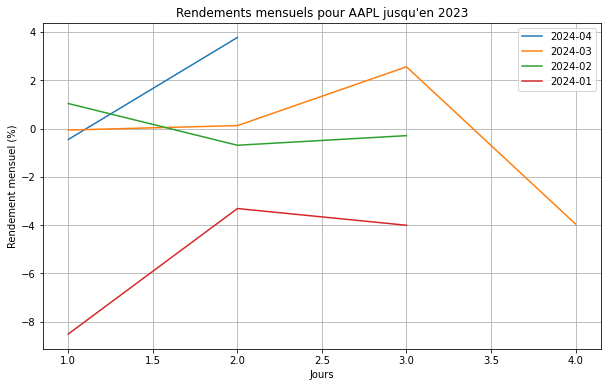